In [31]:
# Zachary Katz
# zachary_katz@mines.edu
# 06 November 2024

"""
Adaptation of MATH 532 Spatial Stats Final Project to demo Rmagic and Fields

Load catalog of GNSS events (soon to be stored in Earthscope)
Create velocity time series for each station
Perform kriging to interpolate velocity between stations using Fields
"""

# Imports and Extensions
import os
import datetime

import scipy
import numpy as np
import pandas as pd
import xarray as xr
import shapefile
import shapely
from shapely.plotting import plot_polygon, plot_line
from shapely.geometry import LineString

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Tides
import timescale
import pyTMD

# Run R commands in Jupyter
%load_ext rpy2.ipython 

#############################
## User-Defined Parameters ##

years = [2014] # Array of years to run
vel_m_yr = 50 # Min velocity to consider for event nucleation
path= '/mnt/c/users/ZacharyKatz/Desktop/Papers/WhillansCatPaper/WhillansCatalogPaper/Events_2stas' # Path to catalog
gl_path = '/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/Antarctica_masksX/scripps_antarctica_polygons_v1.shp' # Path to Grounding Line
## User-Defined Parameters ##
#############################

def derivative(time, x_col, order, crit, spacing):
    """
    Compute the first and second derivative of a smoothed time series
    Parameters
    time - event with times
    x_col - column of x values of which to take the derivative of
    order - order of butterworth filter
    crit - critical value of butterworth filter
    spacing - spacing of gradient
    Returns
    grad - First derivative [list]
    """

    y_data = x_col - np.mean(x_col)

    # 1st derivative
    b, a = scipy.signal.butter(order, crit)
    filtered = scipy.signal.filtfilt(b, a, y_data, padlen=50)
    grad = np.gradient(filtered, spacing)
    return grad


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [8]:
# Load catalog
catalog = []
for year in years:
    for event in os.listdir(f"{path}/{year}_{year}Events2stas"):
        catalog.append(pd.read_csv(f"{path}/{year}_{year}Events2stas/{event}", sep="\t", index_col=0))

# Make velocity vectors
events_with_velocity = []

# Compute average second derivatives of all traces for each event
for event in catalog:
    event.dropna(inplace=True, axis=1)
    data = {"us": [], "vs": [], "xs": [], "ys": [], "times": [],'st_indices': []}

    x_cols = [col for col in event.columns if col.endswith("x")]
    y_cols = [col for col in event.columns if col.endswith("y")]
    
    # Remove all stations that don't have both x and y
    x_cols = [x for x in x_cols if x[:-1] + "y" in y_cols]
    y_cols = [y for y in y_cols if y[:-1] + "x" in x_cols]
    
    grad2s = []
    for x_col in x_cols:
        # Append x, u, t
        data_x = event[x_col]
        data['us'].append(derivative(event["time"], data_x, 4, 0.1, 15))
        data['xs'].append(data_x)
        data['times'].append(pd.to_datetime(event["time"]))

        # Compute 2nd derivative index
        grad = derivative(event["time"], event[x_col], 4, 0.1, 15)
        grad2 = derivative(event["time"], grad, 4, 0.05, 15)
        grad2s.append(grad2)
        

    avg_grad2 = np.nanmean(grad2s, axis=0)
    max_index = np.argmax(avg_grad2)
    data["st_indices"] = max_index

    for y_col in y_cols:
        # Append y, v
        data_y = event[y_col]
        data['vs'].append(derivative(event["time"], data_y, 4, 0.1, 15))
        data['ys'].append(data_y)

    events_with_velocity.append(data)


In [24]:
%%R
# ONLY NEED TO RUN ONCE
install.packages("fields", repos='http://cran.us.r-project.org')

R[write to console]: trying URL 'http://cran.us.r-project.org/src/contrib/fields_17.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 4049945 bytes (3.9 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to cons

x86_64-conda-linux-gnu-cc -I"/home/zkatz/miniconda3/envs/gps/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/zkatz/miniconda3/envs/gps/include -I/home/zkatz/miniconda3/envs/gps/include -Wl,-rpath-link,/home/zkatz/miniconda3/envs/gps/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/zkatz/miniconda3/envs/gps/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1720332503261/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/home/zkatz/miniconda3/envs/gps=/usr/local/src/conda-prefix  -c ExponentialUpperC.c -o ExponentialUpperC.o
x86_64-conda-linux-gnu-cc -I"/home/zkatz/miniconda3/envs/gps/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/zkatz/miniconda3/envs/gps/include -I/home/zkatz/miniconda3/envs/gps/include -Wl,-rpath-link,/home/zkatz/miniconda3/envs/gps/lib    -fpic  -march=nocona -mtune=haswell -ftree

installing to /home/zkatz/miniconda3/envs/gps/lib/R/library/00LOCK-fields/00new/fields/libs
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (fields)
R[write to console]: 

R[write to console]: 
R[write to console]: The downloaded source packages are in
	‘/tmp/RtmpOTEj63/downloaded_packages’
R[write to console]: 
R[write to console]: 

R[write to console]: Updating HTML index of packages in '.Library'

R[write to console]: Making 'packages.html' ...
R[write to console]:  done



In [16]:
dates_timeseries = []
spacing = 4  # Minutes
initial_time = datetime.datetime.strptime("2007-12-01 00:00:00", "%Y-%m-%d %H:%M:%S")
for i in range(24 * 365 * 12 * 15):
    dates_timeseries.append(initial_time + datetime.timedelta(minutes=spacing * i))

In [18]:
st_num = 80 #88 throws fields error
event = events_with_velocity[st_num]
j = event['st_indices'] +10

x_min, x_max = -300000.0, -140000.0
y_min, y_max = -620000.0, -490000.0
gridx = np.arange(x_min,x_max, 1000.0)
gridy = np.arange(y_min, y_max, 1000.0)
x_len = len(gridx)
y_len = len(gridy)
xx,yy = np.meshgrid(gridx,gridy)



x = [event['xs'][i].iloc[j] for i in range(len(event['xs']))] #+ fake_dict['xf']
y = [event['ys'][i].iloc[j] for i in range(len(event['ys']))] #+ fake_dict['yf']
u = [event['us'][i][j] for i in range(len(event['us']))]
v = [event['vs'][i][j] for i in range(len(event['vs']))]
v_mag = [3600 * 24 *np.sqrt(u[i]*u[i] + v[i]*v[i]) for i in range(len(u))] #+ fake_dict['vf']
X = np.array([x,y]).T
y_prime = np.array(v_mag).reshape(-1,1)


In [ ]:
# Calculate nucleation position as coordinates of maximum velocity in the first
# frame where velocity is above a threshold (XX m/yr)

threshold = 30 # m/yr
min_color = 0
max_color = 80
st_num = 0
ed_num = -1


# Kriging Calculation mesh
x_min, x_max = -300000.0, -140000.0
y_min, y_max = -620000.0, -490000.0
gridx = np.arange(x_min,x_max, 500.0)
gridy = np.arange(y_min, y_max, 500.0)
x_len = len(gridx)
y_len = len(gridy)
xx,yy = np.meshgrid(gridx,gridy)

x_maxes = []
y_maxes = []
tide_max = []
times = []
tide_deriv = []
frame = []


# No fake data
x_fake = []
y_fake = []
v_fake = []

for count, event in enumerate(events_with_velocity[st_num:ed_num]): #Loop event
    print(count)
    # At each timestamp grid the velocity using kirging
    j = event['st_indices'] - 10
    found_nucleation = False
    while j < event['st_indices'] + 20 and j < len(event['xs'][0]) and j > 0:
        x = [event['xs'][i].iloc[j] for i in range(len(event['xs']))] + x_fake
        y = [event['ys'][i].iloc[j] for i in range(len(event['ys']))] + y_fake
        u = [event['us'][i][j] for i in range(len(event['us']))]
        v = [event['vs'][i][j] for i in range(len(event['vs']))]
        v_mag = [3600 * 24 *np.sqrt(u[i]*u[i] + v[i]*v[i]) for i in range(len(u))] + v_fake
        
        X = np.array([x,y]).T
        y_prime = np.array(v_mag).reshape(-1,1)
        
        # Kriging in Fields
        %R -i X,y_prime,x_len,y_len -o surf,x_g,y_g 
        %R library(fields)
        %R obj <- spatialProcess(X, y_prime,smoothness=1, aRange=30000) #finer grid search, or fix aRange
        %R fit<- predictSurface( obj, nx=x_len, ny=y_len,extrap=TRUE)
        %R -o surf surf = fit$z
        %R -o x_g x_g=fit$x
        %R -o y_g y_g=fit$y
        
        max_v = np.max(surf)
        if max_v > threshold:
            frame.append(j)
            max_index = np.where(surf == max_v)
            j_max = j
            j = len(event['xs'][0])
            found_nucleation = True

        j = j + 1
      
    if found_nucleation:
        x_maxes.append(gridx[max_index[0][0]])
        y_maxes.append(gridy[max_index[1][0]])

0


KeyError: "'surf' not found"

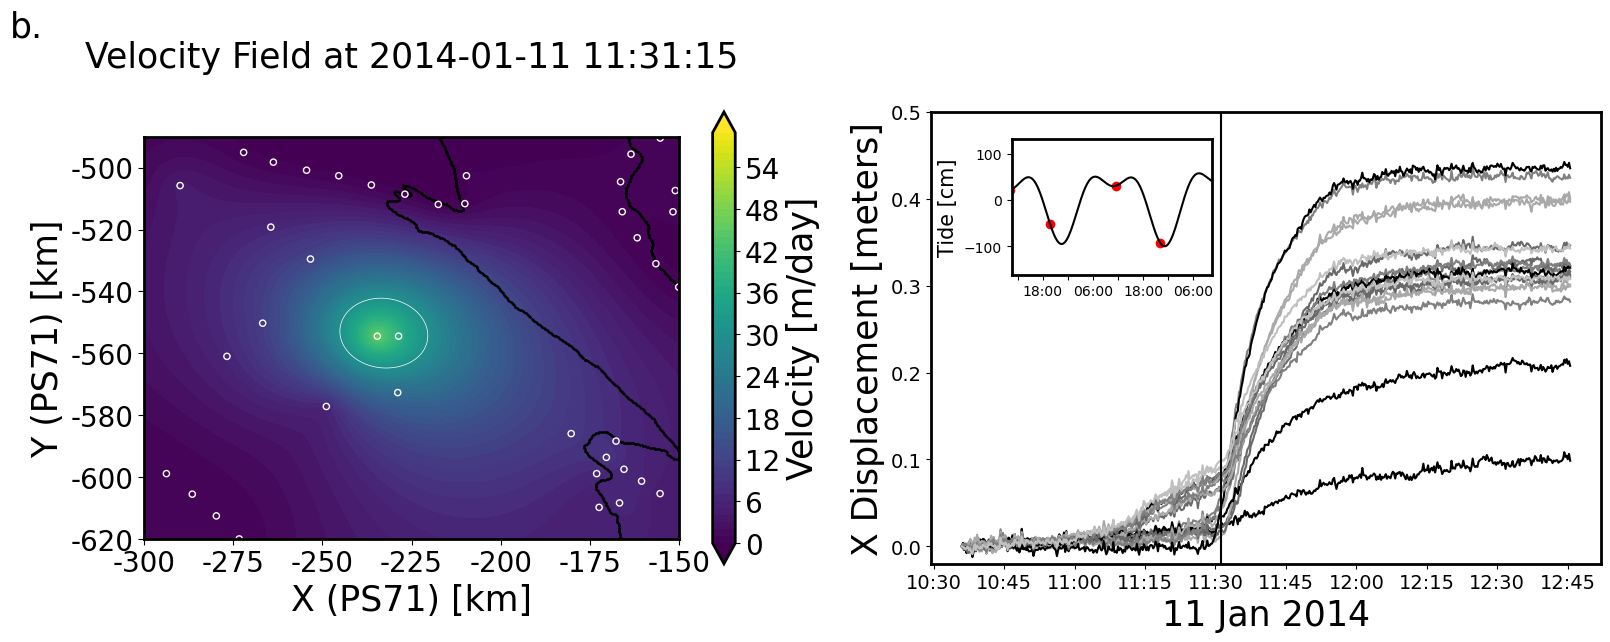

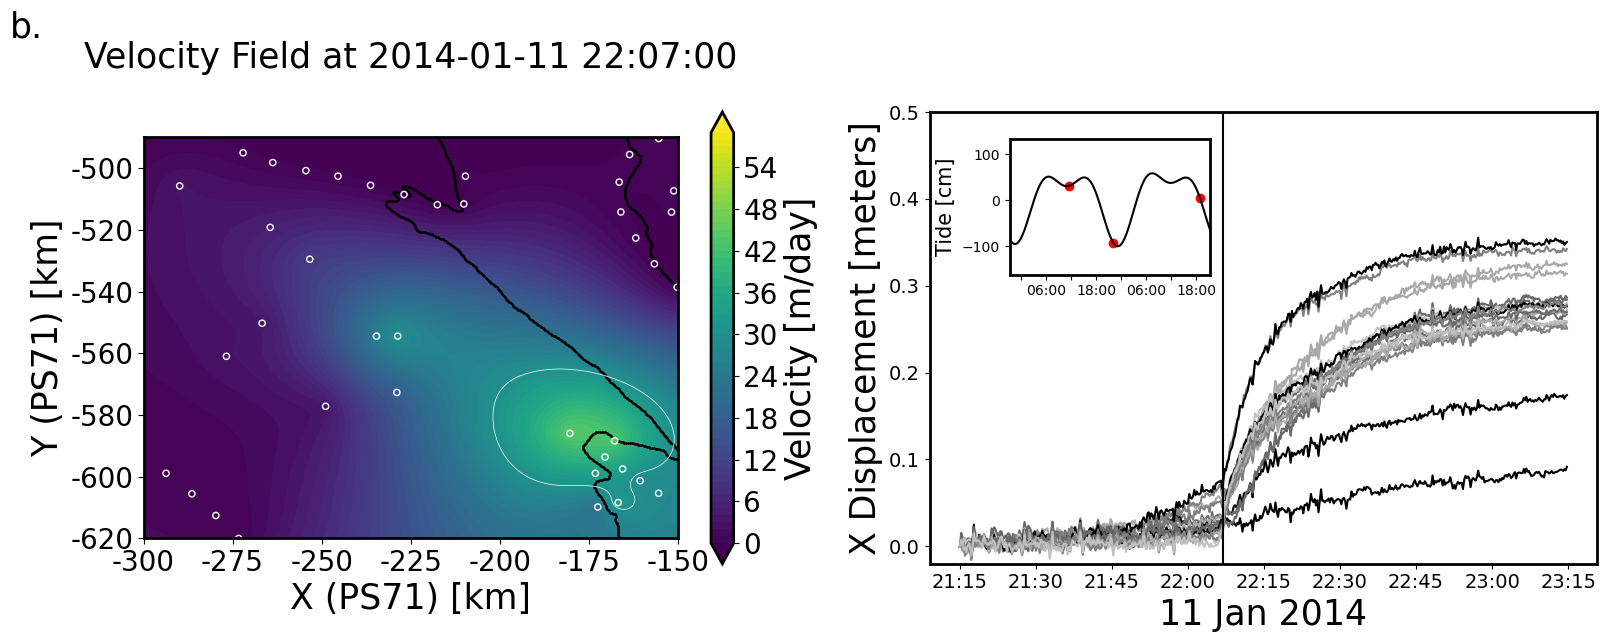

In [ ]:
# Plot the frames found above
min_color = 0
max_color = 60

x_min, x_max = -300000.0,-150000.0
y_min, y_max = -620000.0, -490000.0
gridx = np.arange(x_min,x_max, 500.0)
gridy = np.arange(y_min, y_max, 500.0)
x_len = len(gridx)
y_len = len(gridy)
xx,yy = np.meshgrid(gridx,gridy)

for count, event in enumerate(events_with_velocity[st_num:ed_num]): #Loop event
    cnt = count+st_num
    if cnt in [16,17]:
        
        # At each timestamp grid the velocity using kirging
        j = frame[count] + 4
        x = [event['xs'][i].iloc[j] for i in range(len(event['xs']))] + x_fake
        y = [event['ys'][i].iloc[j] for i in range(len(event['ys']))] + y_fake
        u = [event['us'][i][j] for i in range(len(event['us']))]
        v = [event['vs'][i][j] for i in range(len(event['vs']))]
        v_mag = [3600 * 24 *np.sqrt(u[i]*u[i] + v[i]*v[i]) for i in range(len(u))] + v_fake
        
        X = np.array([x,y]).T
        y_prime = np.array(v_mag).reshape(-1,1)

        X = np.array([x,y]).T
        y_prime = np.array(v_mag).reshape(-1,1)

        # This needs to be on one line to be in the for loop :(
        %R -i xx,yy,X,y_prime,x_len,y_len -o surf,x_g,y_g library(fields); obj <- spatialProcess(X, y_prime,smoothness=0.5); fit<- predictSurface( obj, nx=x_len, ny=y_len,extrap=TRUE); surf = fit$z; x_g=fit$x; y_g=fit$y
            

        # Plot
        #fig, ax = plt.subplots(figsize=[(x_max-x_min)/100000 * 6,(y_max-y_min)/100000 * 6])
        fig = plt.figure(figsize=(16, 6))
        ax = fig.add_subplot(1,2,1, adjustable='box', aspect=((y_max-y_min)/(x_max-x_min)))
        ax2 = fig.add_subplot(1,2,2)


        clr = ax.contourf(x_g, y_g, surf.T, levels=np.arange(min_color, max_color, 1), cmap='viridis',norm=mpl.colors.Normalize(vmin=min_color,vmax=max_color),extend='both')
        cbar = fig.colorbar(clr)
        cbar.set_label('Velocity [m/day]',size=25)
        cbar.ax.tick_params(labelsize=20)

        ax.contour(x_g, y_g, surf.T, levels=[30], colors='white', linewidths=0.5)

        ax.set_xlim(x_min,x_max)
        ax.set_ylim(y_min,y_max)
        KM_SCALE = 1e3
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/KM_SCALE))
        ax.xaxis.set_major_formatter(ticks_x)
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/KM_SCALE))
        ax.yaxis.set_major_formatter(ticks_y)
        ax.set_xlabel('X (PS71) [km]',size=25)
        ax.set_ylabel('Y (PS71) [km]',size=25)
        ax.tick_params(labelsize=20)
        ax.tick_params(size=4)

        #ax.scatter(x_tide,y_tide, c='black', s=1)
        ax.scatter(x,y,c=v_mag,s=20, norm=mpl.colors.Normalize(vmin=min_color,vmax=max_color),cmap='viridis',edgecolors='white')
        ax.set_title(f"Velocity Field at {event['times'][0].iloc[j]}",size=25, pad=50)

        first = True
        colors = ['black','dimgray','darkgray','gray','black','dimgray','darkgray','gray','black','dimgray','darkgray','gray','silver','black','dimgray','darkgray','gray','silver','black','dimgray','darkgray','gray','silver']
        for i, x_col in enumerate(event["xs"]):
            demeaned_to_0 = (x_col - np.mean(x_col)) - (
                x_col.iloc[0] - np.mean(x_col)
            )
            if not np.isnan(x_col).all():
                if first:
                    ax2_dummy = demeaned_to_0
                    first = False
                ax2.plot(event['times'][0], demeaned_to_0, color=colors[i])
        ax2.set_ylabel("X Displacement [meters]",size=25)
       
        ax2.vlines(event['times'][0].iloc[j],-0.5,10,color='black')
        ax2.set_ylim(-0.02,0.5)
        # Fix dates
        ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

        # Setup dates using second axis

        ax2.tick_params(labelsize=14)
        ax2.set_xlabel('11 Jan 2014',size=25)
        
        axins2 = ax2.inset_axes([.12, .64, .3, .3])
        x_min_in = event['times'][0].iloc[0] - datetime.timedelta(days=1)
        x_max_in = event['times'][0].iloc[0] + datetime.timedelta(days=1)
        x_min_in = pd.to_datetime(x_min_in)
        x_max_in = pd.to_datetime(x_max_in)
        axins2.plot(tide['time'], tide['tide'], c='black')
        axins2.set_xlim(x_min_in, x_max_in)
        axins2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        for label in axins2.get_xticklabels()[::2]:
            label.set_visible(False)
        axins2.scatter(tide_evt['time'], tide_evt['tide'], c='red')
        axins2.set_ylabel('Tide [cm]',size=15)
        axins2.tick_params(labelsize=10)

        ax.annotate("b.", (-0.25, 1.25), xycoords="axes fraction", fontsize=25)

        
        
        fig.tight_layout()

In [30]:
print(x_maxes, y_maxes, tide_max)
print(len(x_maxes), len(y_maxes), len(tide_max))
x_fixes = x_maxes
y_fixes = y_maxes
#x_fixes = [x_maxes[i][0] for i in range(len(x_maxes))]
#y_fixes = [y_maxes[i][0] for i in range(len(y_maxes))]
print(x_fixes)
print(y_fixes)
print(tide_deriv)
# Convert times to total seconds
times = [time.timestamp() - times[0].timestamp() for time in times]
times = [(time - times[0])/3660/24/365 for time in times]

[] [] []
0 0 0
[]
[]
[]


In [27]:
def kriging(st_num:int,num_evts:int,fake_data:dict,events_with_velocity:list,x_grid: list, y_grid:list) -> dict:
    """Kriging using R fields library.

    Parameters
    ----------
    st_num : int
        Event number to start with
    num_evts : int
        Number of events to loop through
    fake_data : dict
        Dictionary containing fake station data xf,yf,vf
    events_with_velocity : list
        List of events with velocity data
    interp_grid : list
        Grid of points to interpolate on
    """
    x_grids = []
    y_grids = []
    surf_grids = []
    js = []
    v_mags = []
    
    for count, event in enumerate(events_with_velocity[st_num:st_num+1]): #Loop event
        # At each timestamp grid the velocity using kirging
        for j in range(event['st_indices'] -5, event['st_indices'] + 15):
            x = [event['xs'][i].iloc[j] for i in range(len(event['xs']))] + fake_data['xf']
            y = [event['ys'][i].iloc[j] for i in range(len(event['ys']))] + fake_data['yf']
            u = [event['us'][i][j] for i in range(len(event['us']))]
            v = [event['vs'][i][j] for i in range(len(event['vs']))]
            v_mag = [3600 * 24 *np.sqrt(u[i]*u[i] + v[i]*v[i]) for i in range(len(u))] + fake_data['vf']

            X = np.array([x,y]).T
            y_prime = np.array(v_mag).reshape(-1,1)

            # Kriging in Fields
            %R -i X,y_prime,x_len,y_len -o surf,x_g,y_g 
            %R library(fields)
            %R obj <- spatialProcess(X, y_prime,smoothness=1,aRange=10000) #finer grid search, or fix aRange
            %R fit <- predictSurface(obj,nx=500,ny=500, extrap=TRUE)
            %R -o surf surf = fit$z
            %R -o x_g x_g=fit$x
            %R -o y_g y_g=fit$y
            
            x_grids.append(x_g)
            y_grids.append(y_g)
            surf_grids.append(surf)
            js.append(j)
            v_mags.append(v_mag)
            xs.append(x)
            ys.append(y)
            

    krig_dict = {'x':x_grids,'y':y_grids,'surf':surf_grids,'j':js,'v_mag':v_mags}
    return krig_dict

    



In [29]:
# Run kriging without fake data
st_num = 1 # 88 throws a fields error
num_evts = 1

x_min, x_max = -300000.0, -140000.0
y_min, y_max = -620000.0, -490000.0
gridx = np.arange(x_min,x_max, 1000.0)
gridy = np.arange(y_min, y_max, 1000.0)
x_len = len(gridx)
y_len = len(gridy)
xx,yy = np.meshgrid(gridx,gridy)

dates_timeseries_sec = [time.timestamp() for time in dates_timeseries]
# No fake data
x_fake = []
y_fake = []
v_fake = []

# Include fake data
#x_fake = xs.copy()
#y_fake = ys.copy()
#v_fake = [vel_m_day] * len(xs)

fake_dict = {'xf':x_fake,'yf':y_fake,'vf':v_fake}

k_dict = kriging(st_num,num_evts,fake_dict,events_with_velocity,gridx,gridy)

KeyError: "'surf' not found"

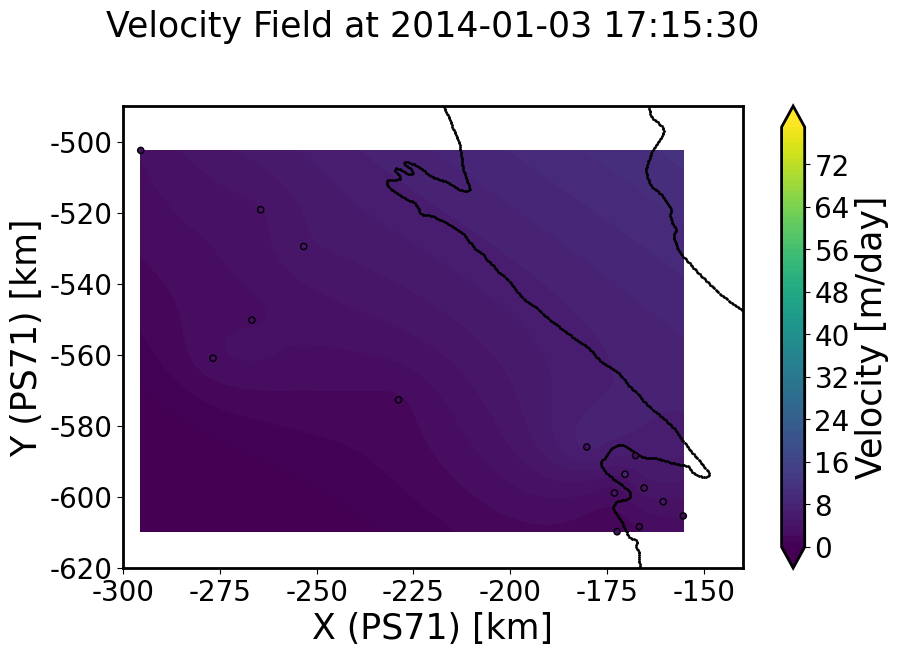

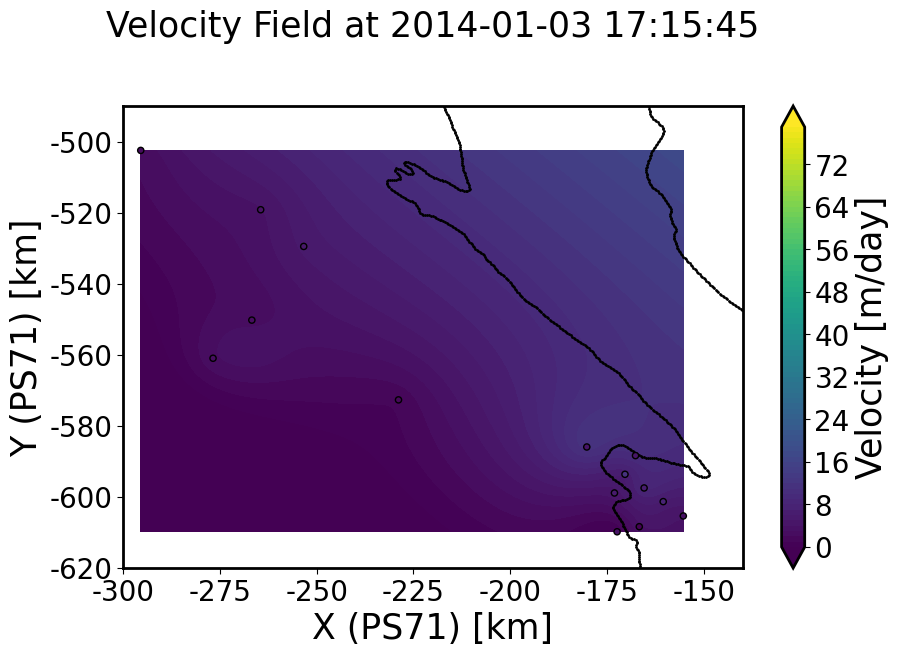

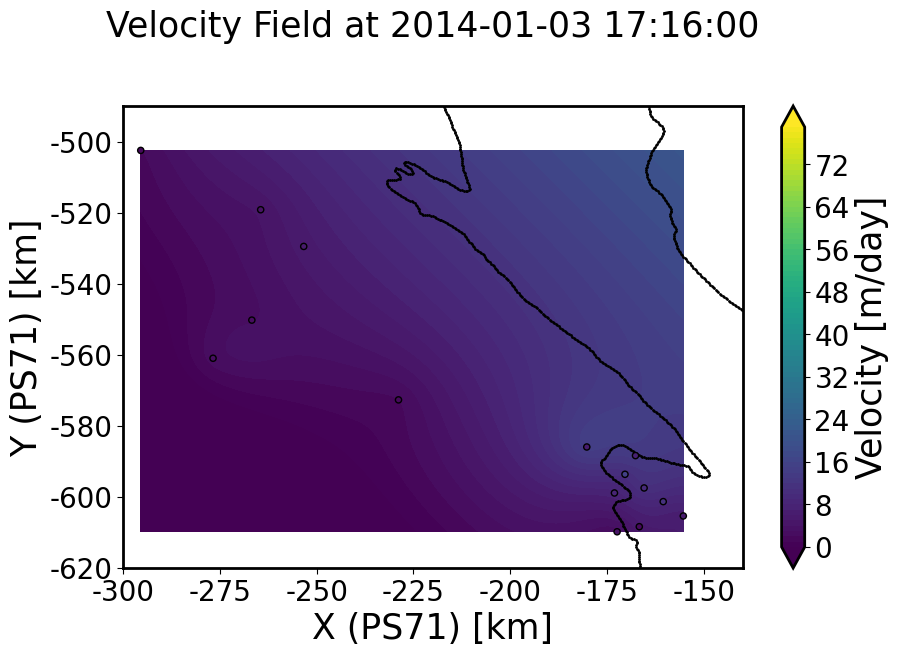

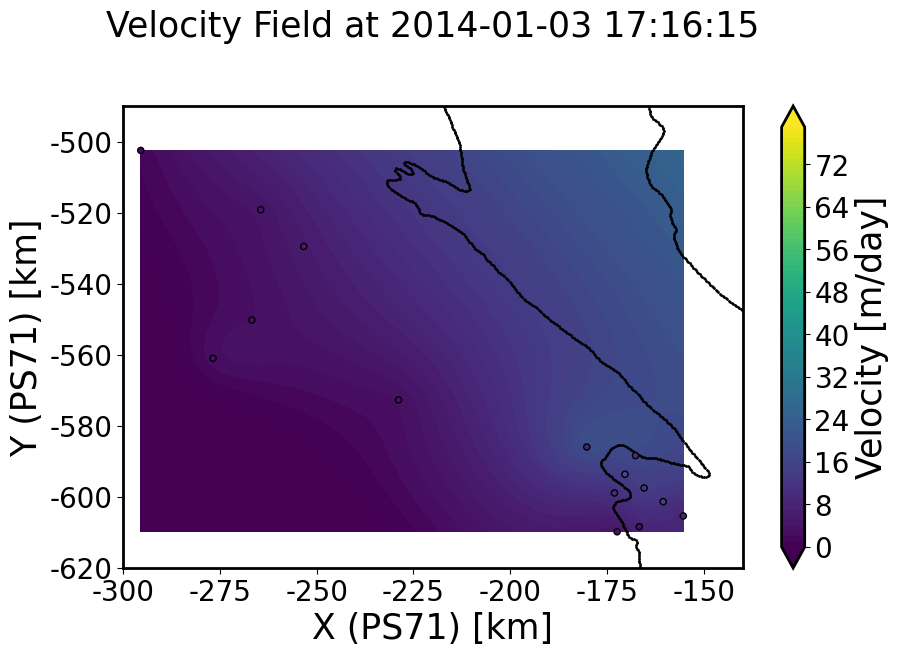

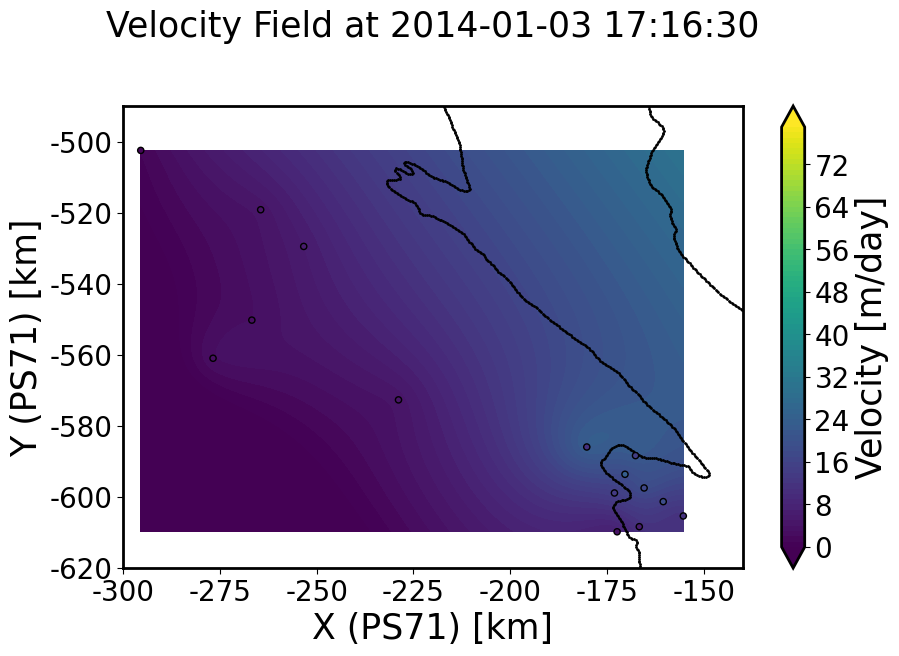

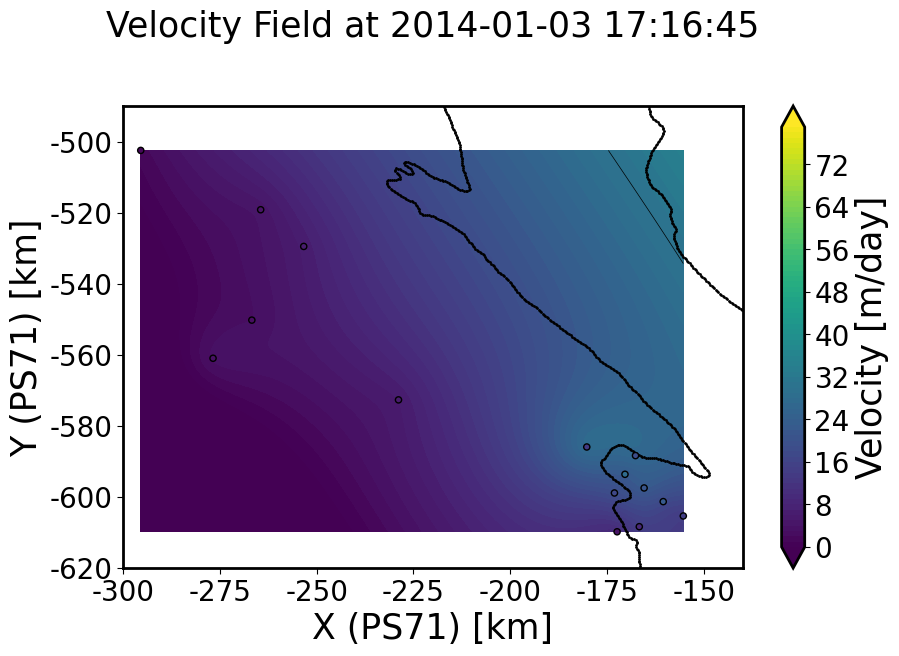

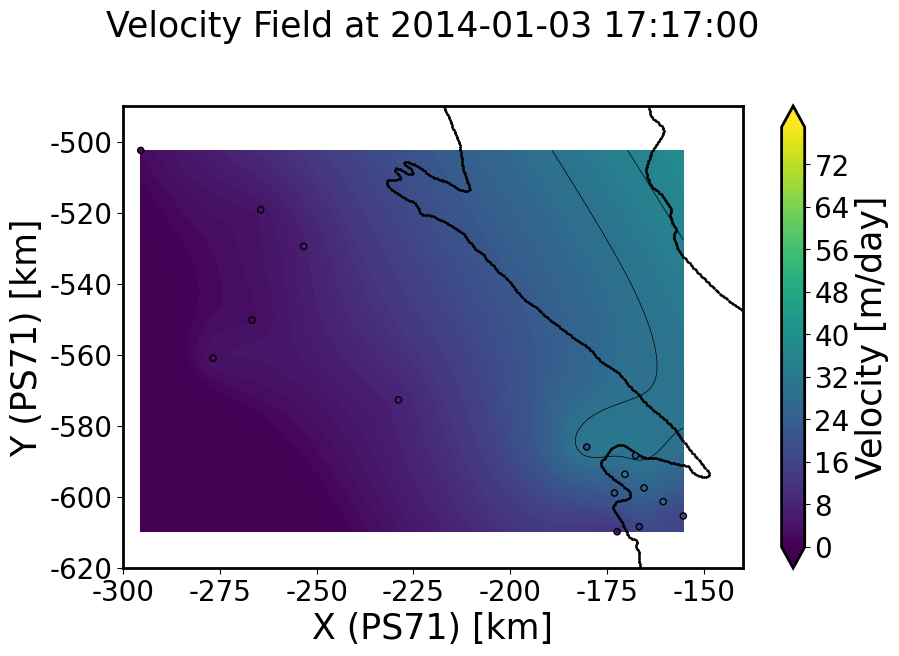

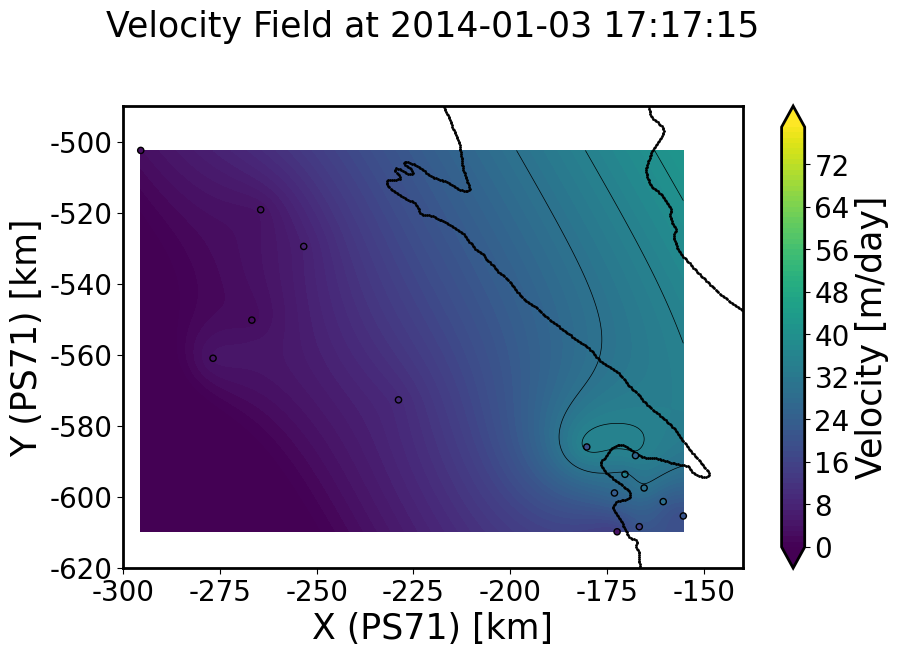

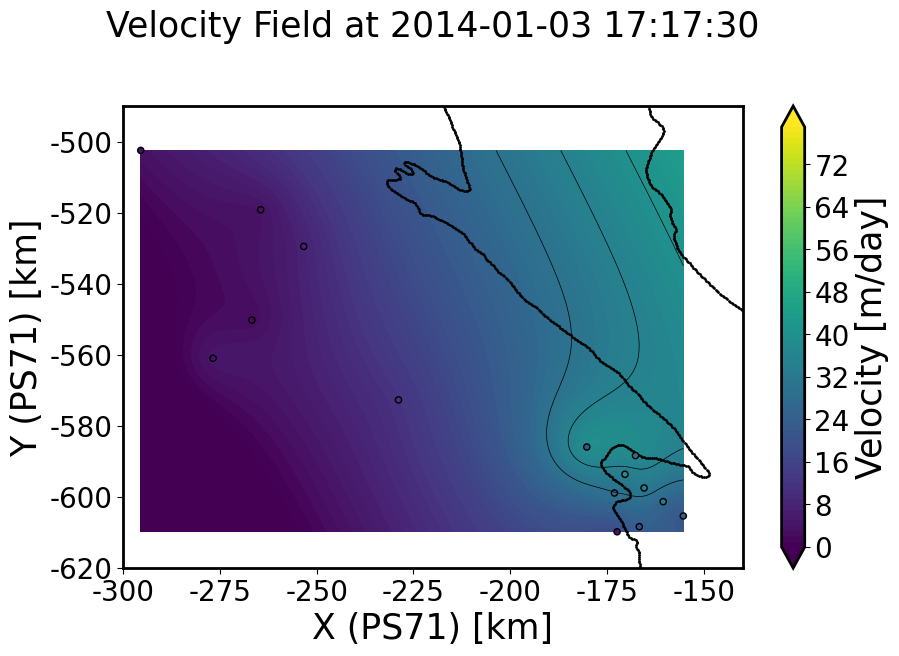

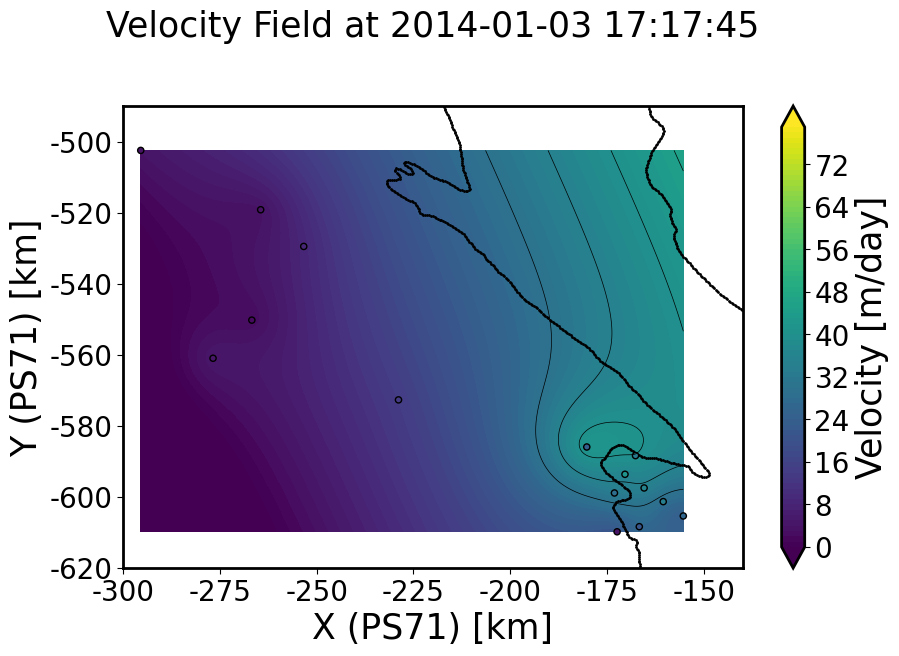

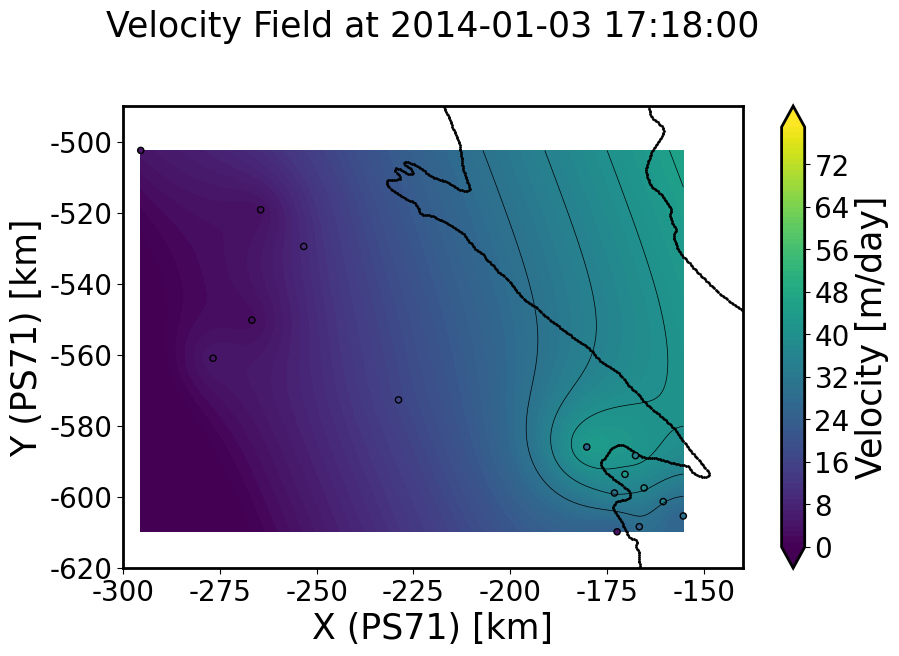

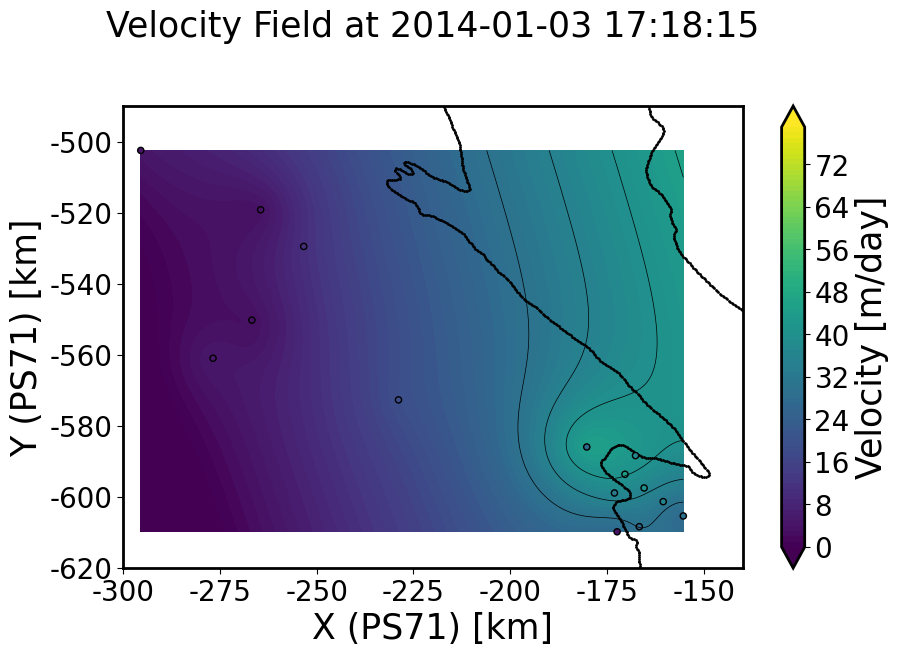

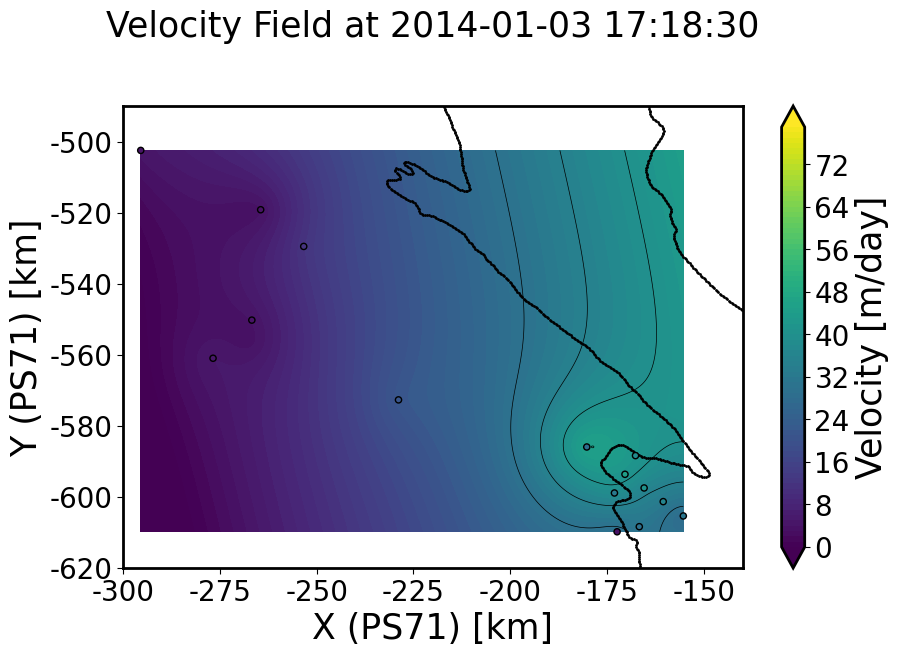

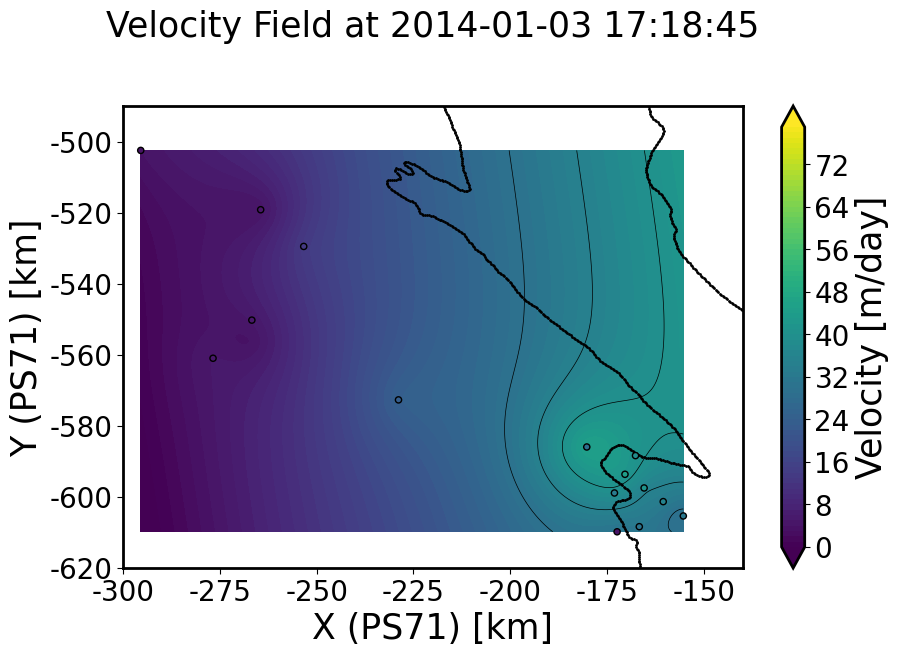

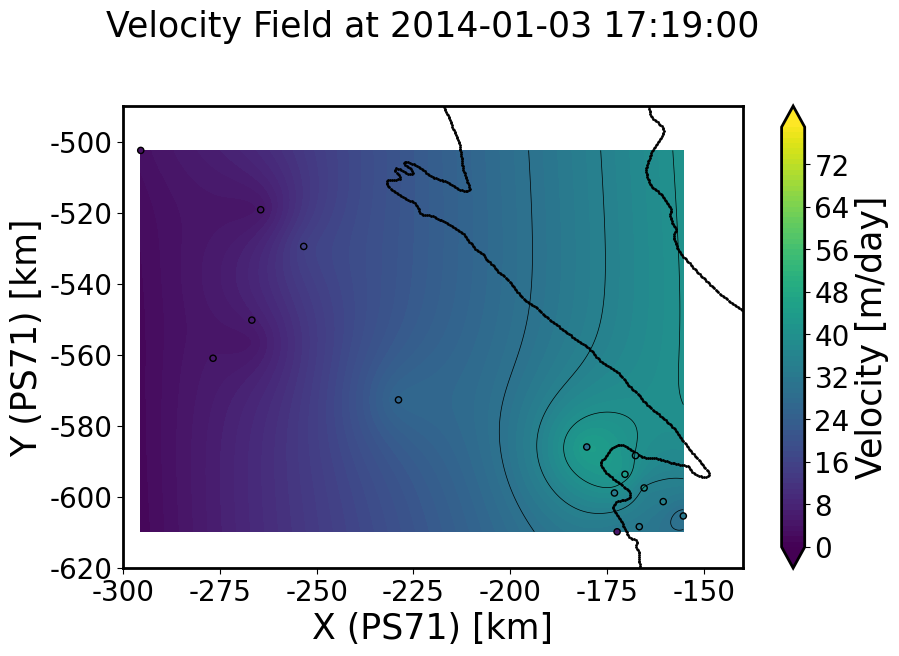

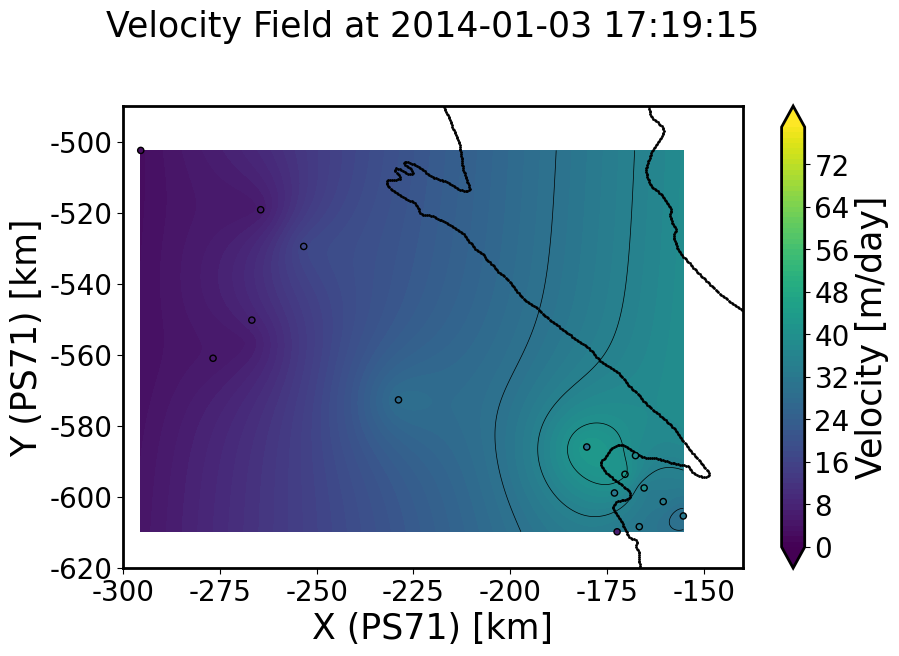

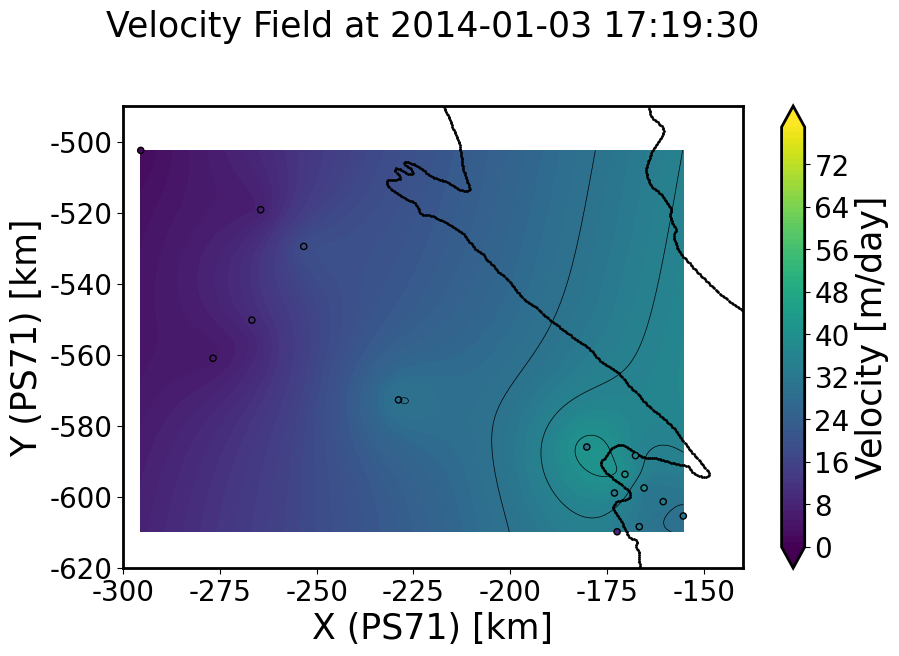

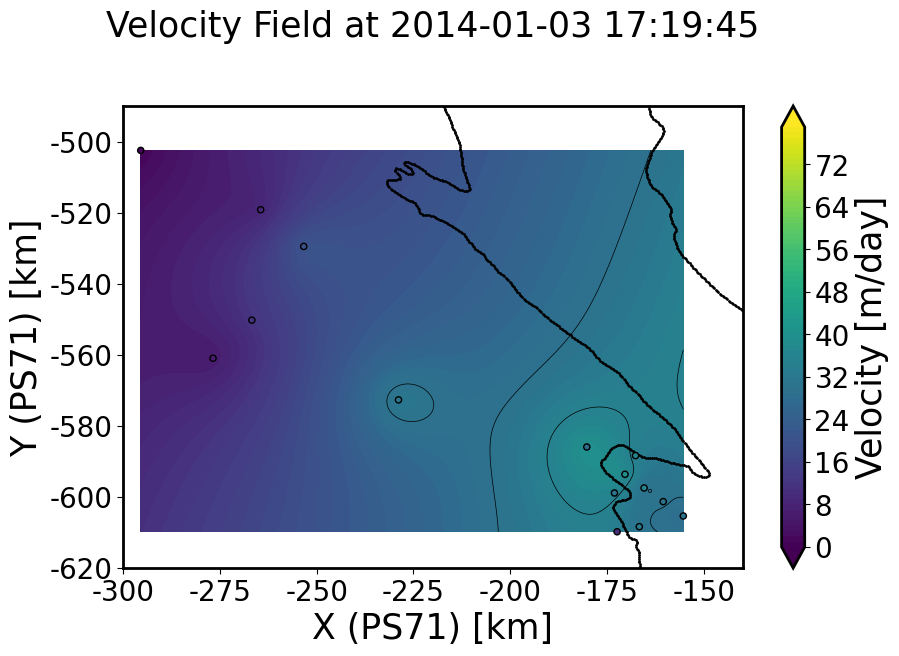

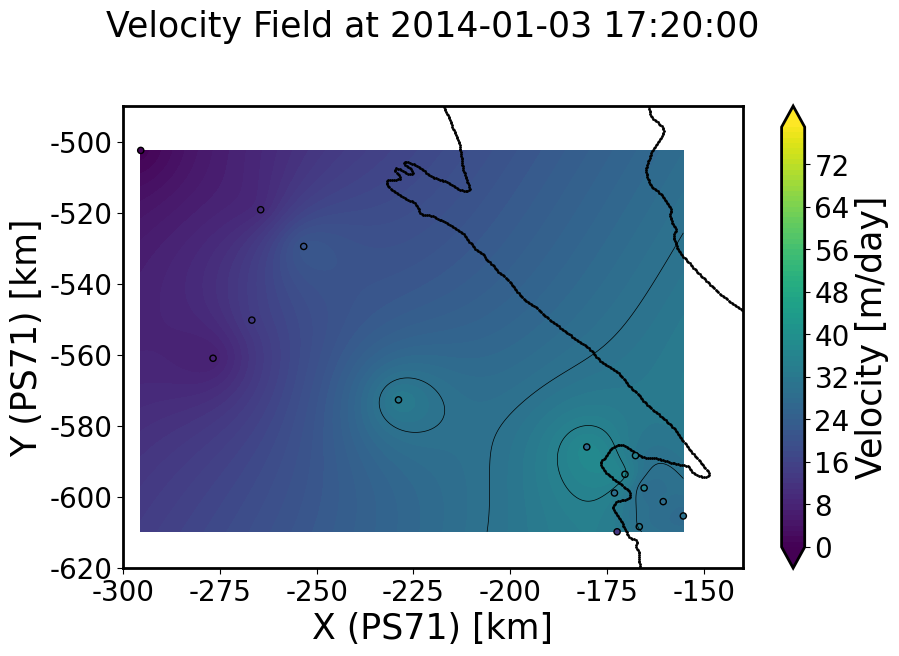

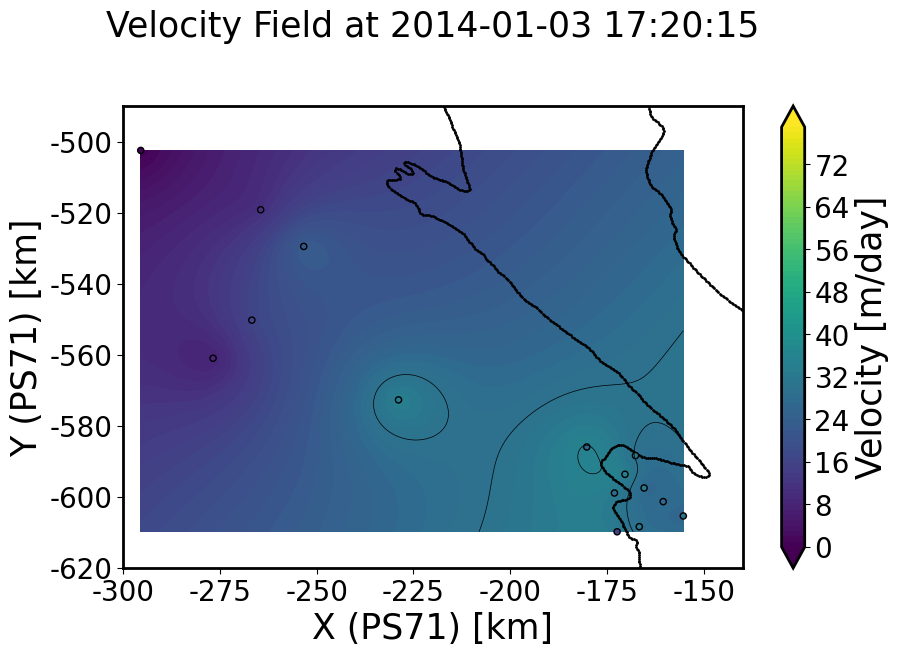

In [140]:
# Plot
# Plot the frames found above
min_color = 0
max_color = 80

j = k_dict['j'][0]
xp = [event['xs'][i].iloc[j] for i in range(len(event['xs']))] + fake_dict['xf']
yp = [event['ys'][i].iloc[j] for i in range(len(event['ys']))] + fake_dict['yf']
u = [event['us'][i][j] for i in range(len(event['us']))]
v = [event['vs'][i][j] for i in range(len(event['vs']))]
v_mag = [3600 * 24 *np.sqrt(u[i]*u[i] + v[i]*v[i]) for i in range(len(u))] + fake_dict['vf']

for v_mag, j, x_g, y_g, surf in zip(k_dict['v_mag'],k_dict['j'],k_dict['x'],k_dict['y'],k_dict['surf']):
    fig, ax = plt.subplots(figsize=(10, 6))

    clr = ax.contourf(x_g, y_g, surf.T, levels=np.arange(min_color, max_color, 1), cmap='viridis',norm=mpl.colors.Normalize(vmin=min_color,vmax=max_color),extend='both')
    cbar = fig.colorbar(clr)
    cbar.set_label('Velocity [m/day]',size=25)
    cbar.ax.tick_params(labelsize=20)

    ax.contour(x_g, y_g, surf.T, levels=[30,35,40,45,50,55], colors='black', linewidths=0.5)

    ax.set_xlim(x_min,x_max)
    ax.set_ylim(y_min,y_max)
    KM_SCALE = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/KM_SCALE))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/KM_SCALE))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_xlabel('X (PS71) [km]',size=25)
    ax.set_ylabel('Y (PS71) [km]',size=25)
    ax.tick_params(labelsize=20)
    ax.tick_params(size=4)

    ax.scatter(x_tide,y_tide, c='black', s=1)
    ax.scatter(xp,yp,c=v_mag[:len(yp)],s=20, norm=mpl.colors.Normalize(vmin=min_color,vmax=max_color),cmap='viridis',edgecolors='black')
    ax.set_title(f"Velocity Field at {event['times'][0].iloc[j]}",size=25, pad=50)